<a href="https://colab.research.google.com/github/JumpNShootMan/TP_MachineLearning/blob/Braulio-Balde%C3%B3n/TP_ML_Decision_Tree_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opencv-python==3.4.2.16
!pip install opencv-contrib-python==3.4.2.16

     |████████████████████████████████| 25.0MB 163kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
     |████████████████████████████████| 30.6MB 143kB/s 
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [2]:
import cv2
import pandas as pd
import numpy as np

In [3]:
data = pd.read_csv('https://raw.githubusercontent.com/JumpNShootMan/TP_MachineLearning/master/datos_banco.csv', encoding='latin-1')

data.head(10)

,idPrestamo,target,monthly_debt_capacity,var_employment_time_in_months,approved_amount,approved_term,approved_interest_amount,var_net_income,person_gender,credit_history_marital_status,var_max_sbs_qual_12m,person_degree_type_desc,default_request_term,default_request_amount
0,LIBDISP9832897855,1,252.39,9.0,"1,200",6,289.11,1140.125000,MALE,C,NORMAL,Secundaria,1,0
1,LIBDISP9021501745,1,244.57,50.0,"2,200",12,696.15,1061.375000,FEMALE,S,NORMAL,Secundaria,0,0
2,LIBDISP4057314971,0,491.5,64.0,"1,000",3,84.99,2082.196667,FEMALE,S,NORMAL,Secundaria,0,0
3,LIBDISP8375185888,0,848.65,77.0,"1,500",6,221.53,3422.423333,MALE,S,NORMAL,Universitaria,0,0
4,LIBDISP9694463037,0,470.52,82.0,"1,000",3,91.34,1882.090000,FEMALE,S,NORMAL,Universitaria,1,0
5,LIBDISP0492929616,0,490.77,79.0,"1,500",6,221.53,2448.016667,MALE,S,NORMAL,Carrera TÃÂ©cnica,1,0
6,LIBDISP6813272232,0,428.57,71.0,"4,000",12,"1,109.56",1803.923333,FEMALE,S,NORMAL,Universitaria,0,0
7,LIBDISP8862427268,1,647.87,4.0,"1,200",6,289.11,2660.630000,MALE,S,NORMAL,Secundaria,1,0
8,LIBDISP7167831610,0,694.23,NaN,900,6,149.79,2912.158333,FEMALE,C,CPP,Universitaria,1,0
9,LIBDISP3835927929,1,209.48,77.0,"1,000",6,152.32,2498.043333,MALE,S,NORMAL,Secundaria,1,0


In [4]:
data.dtypes

idPrestamo                        object
target                             int64
monthly_debt_capacity             object
var_employment_time_in_months    float64
approved_amount                   object
approved_term                      int64
approved_interest_amount          object
var_net_income                   float64
person_gender                     object
credit_history_marital_status     object
var_max_sbs_qual_12m              object
person_degree_type_desc           object
default_request_term               int64
default_request_amount             int64
dtype: object

# Pre-procesamiento

In [5]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

Eliminación de atributos innecesarios para la tarea de clasificación. 'idPrestamo' por ser un indice y 'default_request_amount' por solo tener data de uno de sus valores '0'.

In [6]:
del data["idPrestamo"]
del data["default_request_amount"]

Union de las instancias con valor 'Carrera TÃÂ©cnica' y 'Carrera TÌÄå©cnica' en un solo valor 'Carrera Tecnica'.

In [7]:
for i in range(len(data['person_degree_type_desc'])):
  if data['person_degree_type_desc'][i] == "Carrera TÃÂ©cnica" or data['person_degree_type_desc'][i] == "Carrera TÌÄå©cnica":
    data['person_degree_type_desc'][i] = "Carrera Tecnica"

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


OneHotEnconding para los atributos cualitativos.

In [8]:
def oneHotEncoding(feature):
  onehot_encoded = pd.get_dummies(data[feature], prefix=feature)
  del data[feature]
  return data.join(onehot_encoded)

In [9]:
data = oneHotEncoding('person_gender')
data = oneHotEncoding('credit_history_marital_status')
data = oneHotEncoding('var_max_sbs_qual_12m')
data = oneHotEncoding('person_degree_type_desc')

Transformación de los valores tipo object a valores numéricos.

In [10]:
for i in data:
  for j in range(len(data[i])):
    if type(data[i][j]) == str:
      data[i][j] = data[i][j].replace(',', '')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [11]:
for i in data:
  if data[i].dtype == object:
    data[i] = pd.to_numeric(data[i])

Remplazo de valores faltantes utilizando SimpleImputer.

In [12]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
data.var_employment_time_in_months = imputer.fit_transform(data['var_employment_time_in_months'].values.reshape(-1,1))

Normalización MinMax para los valores que originalmente eran cuantitativos, excepto 'approved_term' porque son meses.

In [13]:
def standardization(feature):
  scaler = MinMaxScaler()
  return scaler.fit_transform(data[feature].values.reshape(-1,1))

In [14]:
data['monthly_debt_capacity'] = standardization('monthly_debt_capacity')
data['var_employment_time_in_months'] = standardization('var_employment_time_in_months')
data['approved_amount'] = standardization('approved_amount')
data['approved_interest_amount'] = standardization('approved_interest_amount')
data['var_net_income'] = standardization('var_net_income')

In [15]:
data.head(10)

,target,monthly_debt_capacity,var_employment_time_in_months,approved_amount,approved_term,approved_interest_amount,var_net_income,default_request_term,person_gender_FEMALE,person_gender_MALE,credit_history_marital_status_C,credit_history_marital_status_D,credit_history_marital_status_S,credit_history_marital_status_V,var_max_sbs_qual_12m_CPP,var_max_sbs_qual_12m_DEFICIENTE,var_max_sbs_qual_12m_DUDOSO,var_max_sbs_qual_12m_NORMAL,var_max_sbs_qual_12m_PERDIDA,person_degree_type_desc_Carrera Tecnica,person_degree_type_desc_Postgrado,person_degree_type_desc_Primaria,person_degree_type_desc_Secundaria,person_degree_type_desc_Universitaria
0,1,0.055545,0.113636,0.059829,6,0.116370,0.039883,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0
1,1,0.054488,0.579545,0.145299,12,0.294249,0.037128,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
2,0,0.087848,0.738636,0.042735,3,0.027169,0.072837,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
3,0,0.136099,0.886364,0.085470,6,0.086837,0.119720,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1
4,0,0.085014,0.943182,0.042735,3,0.029944,0.065837,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1
5,0,0.087750,0.909091,0.085470,6,0.086837,0.085634,1,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0
6,0,0.079347,0.818182,0.299145,12,0.474912,0.063103,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1
7,1,0.108974,0.056818,0.059829,6,0.116370,0.093071,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0
8,0,0.115237,0.397495,0.034188,6,0.055487,0.101870,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1
9,1,0.049748,0.886364,0.042735,6,0.056592,0.087384,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0


# Decision Tree Classifier

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV

Separación de la data y los labels.

In [17]:
X = data.iloc[:,1:]
y = data.target

Separación de la data con 20% de test y 80% para train.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10)

Creación del modelo, predicción de la test data, impresión de la matriz de confusión y reporte de métricas: 'precision', 'recall', 'f1-score', 'accuracy'.

In [19]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[90 29]
 [36 17]]
              precision    recall  f1-score   support

           0       0.71      0.76      0.73       119
           1       0.37      0.32      0.34        53

    accuracy                           0.62       172
   macro avg       0.54      0.54      0.54       172
weighted avg       0.61      0.62      0.61       172



Reporte del 'accuracy' resultante de cada fold y su promedio.


In [21]:
scores = cross_val_score(tree, X, y, cv=10)
for i in range(len(scores)):
  print(str(i + 1) + ": " + str(scores[i]))
print("Promedio: " + str(scores.mean()))

1: 0.6337209302325582
2: 0.6046511627906976
3: 0.5813953488372093
4: 0.6046511627906976
5: 0.6046511627906976
6: 0.622093023255814
7: 0.6337209302325582
8: 0.6569767441860465
9: 0.627906976744186
10: 0.5847953216374269
Promedio: 0.6154562763497892


Función para graficar las curvas de validación.

In [22]:
def plotingValidationCurve(model, X, y, param_name, param_range, scoring):
  train_scores, valid_scores = validation_curve(
    model, X, y, param_name=param_name, param_range=param_range,
    cv=10, scoring=scoring)

  mean_training = np.mean(train_scores, axis=1) 
  mean_validation = np.mean(valid_scores, axis=1) 

  plt.plot(param_range, mean_training, '--', color="b",  label="Train score")
  plt.plot(param_range, mean_validation, color="g", label="Validation score")
  plt.title("Validation Curve for DecisionTreeClassifier")
  plt.xlabel(param_name)
  plt.ylabel("Score")
  plt.legend(loc="best")
  plt.show()

Curva de validación del parametro 'max_depth', el mejor accuracy es obtenido por una profundidad maxima de 3.

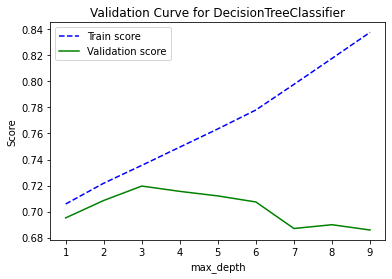

In [23]:
plotingValidationCurve(tree, X, y, 'max_depth', np.arange(1, 10), 'accuracy')

Curva de validación del parametro 'max_depth', los valores 100, 110, 120 y 130 son los más prometedores tanto por la métrica como por ser los más cercanos a la curva de entrenamiento.

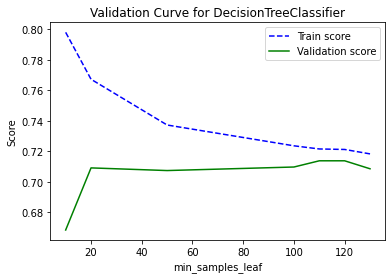

In [24]:
param_range = [10, 20, 50, 100, 110, 120, 130]

plotingValidationCurve(tree, X, y, 'min_samples_leaf', param_range, 'accuracy')

Función para graficar las curvas de aprendizaje.

In [28]:
def plotingLearningCurve(model, X, y, train_sizes, scoring):
  train_sizes, train_scores, valid_scores = learning_curve(
    tree, X, y, scoring=scoring, 
    train_sizes=train_sizes, cv=10) 

  mean_training = np.mean(train_scores, axis=1) 
  mean_validation = np.mean(valid_scores, axis=1) 

  plt.plot(train_sizes, mean_training, '--', color="b",  label="Train score") 
  plt.plot(train_sizes, mean_validation, color="g", label="Validation score") 
    
  plt.title("Learning Curve for Desicion Tree Classifier") 
  plt.xlabel("Training Set Size") 
  plt.ylabel("Accuracy Score") 
  plt.legend(loc="best") 
  plt.show()

Curva de aprenizaje del modelo, se observa que la cura de entrenamiento esta al maximo de score lo que indica overfitting. Por otro lado, la curva del cross-validation es muy variable a lo largo de las iteraciones. Además, entre las curvas hay mucha diferencia lo que indica un escenario de alta varianza. Es recomendable consegir más data o reducir la complejidad del modelo para mejorar el performance de este.

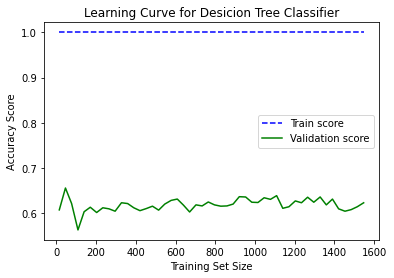

In [29]:
plotingLearningCurve(tree, X, y, np.linspace(0.01, 1.0, 50), 'accuracy')

Definición de los valores posibles para los hiperparámetros del modelo con valores de prueba obtenido de las curvas de validación.

In [30]:
param_grid = {'criterion':['gini','entropy'], 'max_depth':np.arange(1, 5), 'min_samples_leaf':[100, 110, 120, 130]}

Realizamos una busqueda de valores para los hiperparámetros especificados mediante GriSearchCV.

In [31]:
grid = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=10)
grid.fit(X, y)

GridSearchCV(cv=10, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                  

Imprimimos el mejor estimador encontrado en la busqueda.

In [32]:
print(grid.best_estimator_)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=100, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


Empleamos el mejor modelo para realizar una predicción del test data. También, imprimimos la matriz de confusión y el reporte de métricas: 'precision', 'recall', 'f1-score', 'accuracy'.

In [33]:
model = grid.best_estimator_
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[113   6]
 [ 45   8]]
              precision    recall  f1-score   support

           0       0.72      0.95      0.82       119
           1       0.57      0.15      0.24        53

    accuracy                           0.70       172
   macro avg       0.64      0.55      0.53       172
weighted avg       0.67      0.70      0.64       172



Reporte del 'accuracy' resultante de cada fold y su promedio.

In [34]:
scores = cross_val_score(model, X, y, cv=10)
for i in range(len(scores)):
  print(str(i + 1) + ": " + str(scores[i]))
print("Promedio: " + str(scores.mean()))

1: 0.6976744186046512
2: 0.75
3: 0.7093023255813954
4: 0.686046511627907
5: 0.7209302325581395
6: 0.7093023255813954
7: 0.7325581395348837
8: 0.7209302325581395
9: 0.7383720930232558
10: 0.7017543859649122
Promedio: 0.7166870665034679
